<a href="https://colab.research.google.com/github/olhaishchenko/-data_science/blob/master/HW_10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import os
import random
from PIL import Image

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import CategoricalAccuracy
import albumentations as A


In [ ]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(42)

In [ ]:
num_classes = 10
num_features = 28*28
new_size = (32, 32)

lr = 0.001
n_epochs = 10
batch_size = 256

In [ ]:
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Завантажте тренувальний набір даних fashion_mnist
# (train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# # Задайте новий розмір зображень (32x32)
# new_size = (32, 32)

# # Змініть розмір зображень за допомогою функції tf.image.resize
# resized_images = tf.image.resize(train_images, [new_size[0], new_size[1]])

# # Виберіть декілька прикладів для відображення
# num_examples = 5

# plt.figure(figsize=(10, 5))
# for i in range(num_examples):
#     plt.subplot(1, num_examples, i + 1)
#     plt.imshow(resized_images[i], cmap='gray')
#     plt.title(f'Label: {train_labels[i]}')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:

label = \
{
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot",
}


# **Частина 1**

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [ ]:
# Загружаем датасет
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape(-1, 28, 28, 1), x_test.reshape(-1, 28, 28, 1)
x_train, x_test = x_train / 255., x_test / 255.

In [ ]:
idx_sample = 15
plt.imshow(x_train[idx_sample].reshape(28, 28), cmap="gray")
plt.title(label[y_train[idx_sample]])

In [ ]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=256, transforms=None):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size
        self.transforms = transforms

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, n):
        indexes = self.indexes[n * self.batch_size : (n + 1) * self.batch_size]
        batch_x = self.x[indexes]
        batch_y = tf.keras.utils.to_categorical(self.y[indexes], num_classes)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
x_train_part, x_valid, y_train_part, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [ ]:
x_train_part.shape, y_train_part.shape, x_valid.shape, x_test.shape

((48000, 28, 28, 1), (48000,), (12000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)

In [ ]:
X, y = train_dataset[0]
X.shape, y.shape

((256, 28, 28, 1), (256, 10))

In [ ]:
# from tensorflow.keras.initializers import RandomNormal

model = Sequential([
    Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),

    Flatten(),
    Dense(128, activation="relu"),

    Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
# from tensorflow.keras.optimizers import Adam, SGD

model.compile(
    optimizer='rmsprop',
    loss="categorical_crossentropy",
    metrics=[CategoricalAccuracy()],
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    verbose=1,
    callbacks=[callback_early_stopping, callback_save]
)

Epoch 1/20
233/234 [============================>.] - ETA: 0s - loss: 0.6874 - categorical_accuracy: 0.7478
Epoch 1: val_loss improved from inf to 0.42227, saving model to best.hdf5
234/234 [==============================] - 14s 15ms/step - loss: 0.6862 - categorical_accuracy: 0.7483 - val_loss: 0.4223 - val_categorical_accuracy: 0.8422
Epoch 2/20
232/234 [============================>.] - ETA: 0s - loss: 0.3799 - categorical_accuracy: 0.8606
Epoch 2: val_loss improved from 0.42227 to 0.31866, saving model to best.hdf5
234/234 [==============================] - 3s 14ms/step - loss: 0.3798 - categorical_accuracy: 0.8607 - val_loss: 0.3187 - val_categorical_accuracy: 0.8829
Epoch 3/20
233/234 [============================>.] - ETA: 0s - loss: 0.3118 - categorical_accuracy: 0.8858
Epoch 3: val_loss improved from 0.31866 to 0.28411, saving model to best.hdf5
234/234 [==============================] - 3s 13ms/step - loss: 0.3118 - categorical_accuracy: 0.8858 - val_loss: 0.2841 - val_catego

In [ ]:
model.save_weights("my_model.hdf5")

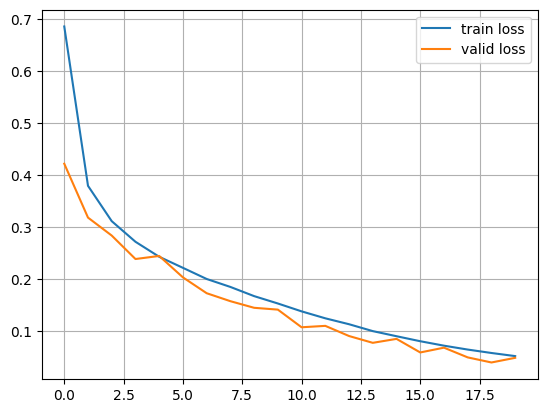

In [ ]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.grid()

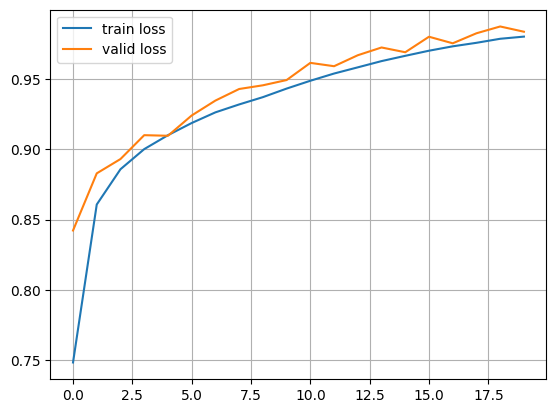

In [ ]:
plt.plot(history.history["categorical_accuracy"], label="train loss")
plt.plot(history.history["val_categorical_accuracy"], label="valid loss")
plt.legend()
plt.grid()

In [ ]:
test_out = model(x_test).numpy()

In [ ]:
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)
print(f"Accuracy test data: {accuracy_test.round(5)}" )

Accuracy test data: 0.9132


**best_task_9**
Epoch 19: val_loss did not improve from 0.12611
234/234 [==============================] - 2s 8ms/step - loss: 0.1414 - categorical_accuracy: 0.9446 - val_loss: 0.1388 - val_categorical_accuracy: 0.9462

        Dense(1024, activation="relu", input_shape=(num_features,)),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(10, activation="softmax"),
optimizer=**Adam**

batch_size=**256** lr=**0.001** n_epochs=**20**

Accuracy test data: **0.897**